In [633]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh, VOL, BND
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot, exp, sqrt, pi, sin

In [1277]:
R = 10.
H = 1.

def CreateMesh( h_max = 2.):
    '''Creates a netgen mesh and returns the NG-solve wrapper.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_p","Gamma","Sigma_n"],
                    leftdomain=1,
                    rightdomain=0)
    geo.AddCircle(c=(0,0),
                r=0.2,
                bc="dOmega",
                leftdomain=2,
                rightdomain=1)
    geo.SetMaterial (1, "Omega_e")
    geo.SetMaterial (2, "Omega_i")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega

def TestMesh( h_max = 2.):
    '''Creates a netgen mesh and returns the NG-solve wrapper.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_p","Gamma","Sigma_n"],
                    leftdomain=1,
                    rightdomain=0)
    geo.SetMaterial (1, "Omega_e")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega



#Omega = CreateMesh()
Omega = TestMesh()

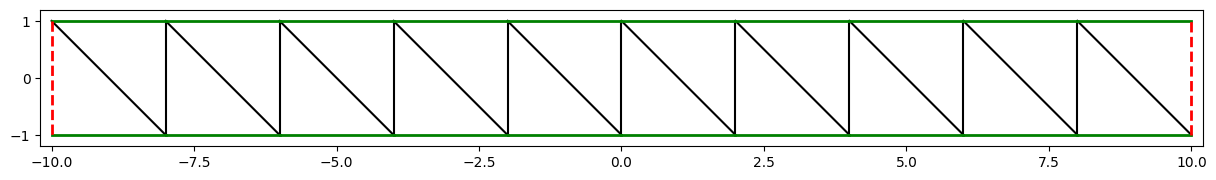

In [1279]:
def plot_mesh( M : Mesh, ax : plt.Axes | None = None): 
    """Plots a mesh"""
    points = np.fromiter( (v.point for v in M.vertices), dtype=np.dtype((float, 2)), count=M.nv)
    
    if ax is None:
        _, ax = plt.subplots( figsize=(15,3))
    for l in M.edges:
        if len(l.faces) == 2:
            px, py = points[l.vertices[0].nr]
            qx, qy = points[l.vertices[1].nr]
            ax.plot( [px, qx], [py, qy], 'k')

    lw = 2

    for e in M.Boundaries("Gamma").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], 'g', linewidth=lw)

    for e in M.Boundaries("Sigma_p").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)

    for e in M.Boundaries("Sigma_n").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)


    for e in M.Boundaries("dOmega").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--b', linewidth=lw)


    #ax.scatter(x=points[:,0], y=points[:,1])
    d = 0.2
    ax.axis('square')
    ax.set_xlim([-R-d,R+d])
    ax.set_ylim([-H-d,H+d])


plot_mesh(Omega)


Lets check for counter clockwise-ness

In [1280]:
# def cross_product(ux, uy, vx, vy):
#     cp = ux*vy - uy*vx
#     return cp

# vertices = list(Omega.vertices)

# triangles = list(Omega.faces)

# def is_counterclockwise(K):
#     px, py = vertices[K.vertices[0].nr].point
#     qx, qy = vertices[K.vertices[1].nr].point
#     rx, ry = vertices[K.vertices[2].nr].point
#     ux = qx - px
#     uy = qy - py 
#     vx = rx - px 
#     vy = ry - py
#     cp = cross_product(ux,uy,vx,vy)
#     return cp > 0

# for K in triangles:
#     print(is_counterclockwise(K))

    

I think its easier if we force it to be counter-clockwise

In [1281]:
# cc_triangles = []
# for K in triangles:
#     if is_counterclockwise(K):
#         cc_triangles.append(K.vertices)
#     else:
#         cc_triangles.append((K.vertices[1],K.vertices[0],K.vertices[2]))

In [1282]:
# def is_counterclockwise(K):
#     px, py = vertices[K[0].nr].point
#     qx, qy = vertices[K[1].nr].point
#     rx, ry = vertices[K[2].nr].point
#     ux = qx - px
#     uy = qy - py 
#     vx = rx - px 
#     vy = ry - py
#     cp = cross_product(ux,uy,vx,vy)
#     return cp > 0


# for K in cc_triangles:
#     print(is_counterclockwise(K))


I need to brute force the definition of K+ and K- 

In [1283]:
Vertices = np.array([ list(v.point) for v in Omega.vertices])
Triangles = [ [ v.nr for v in K.vertices] for K in Omega.faces ]
Sides = [ [ v.nr for v in E.vertices] for E in Omega.edges ]
Baricenters = np.array([ 1/3 * sum([Vertices[v] for v in K]) for K in Triangles ])
MidPoints = np.array([ 1/2 * sum([Vertices[v] for v in s]) for s in Sides] )


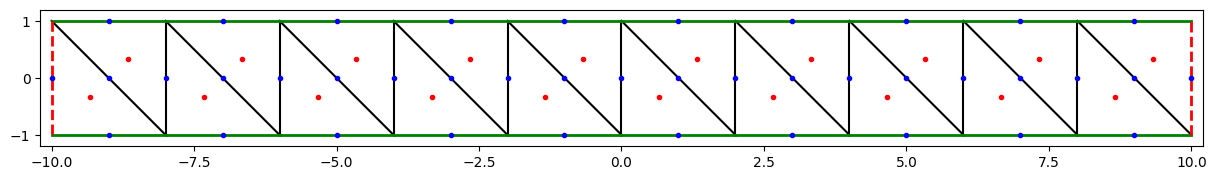

In [1284]:
def CheckPoints(Omega, Baricenters, MidPoints):
    plot_mesh(Omega)
    plt.plot( Baricenters[:,0], Baricenters[:,1],'.r')
    plt.plot( MidPoints[:,0], MidPoints[:,1],'.b')

CheckPoints(Omega, Baricenters, MidPoints)

The vertices in each triangle are not given in a clockwise or counter-clockwise manner in general. For that reason the normal vector is hardcoded.

In [1285]:
from enum import Enum, auto

class EdgeType(Enum):
    INNER = auto()
    GAMMA = auto()
    SIGMA_L = auto()
    SIGMA_R = auto()



class Edge:
    '''Holds all the information from an edge that is needed:
    - P : inital vertex
    - Q : end point
    - N : normal
    - T : tangent
    - Type: EdgeType: {Inner, Gamma, Sigma_L, Sigma_R}
    - Triangless: tuple of one or two element IDs.'''

    def __init__(self, Omega, edge ):
        P = np.array( Omega.vertices[edge.vertices[0].nr].point)
        Q = np.array( Omega.vertices[edge.vertices[1].nr].point)        
        self.P = P
        self.Q = Q
        self.Type = self.getEdgeType()
        self.N = self.getNormal()
        self.T = self.getTangent() 
        self.midpoint = (P+Q)/2
        self.Triangles = self.setTriangles(Omega,edge)


#        probably they should be properties with getters and setters, fix later    

    def getEdgeType(self):
        px, py = self.P 
        qx, qy = self.Q 
        e = 1E-3
        # THIS SHOULD BE RETRIEVED FROM THE NETGEN LABELS
        if np.abs(py-qy)<e and np.abs(py-H)<e:
            return EdgeType.GAMMA
        if np.abs(py-qy)<e and np.abs(py+H)<e:
            return EdgeType.GAMMA
        if np.abs(px-qx)<e and np.abs(px-R)<e:
            return EdgeType.SIGMA_R
        if np.abs(px-qx)<e and np.abs(px+R)<e:
            return EdgeType.SIGMA_L
        else:
            return EdgeType.INNER

    def getNormal(self):
        px, py = self.P 
        qx, qy = self.Q 
        tx, ty = self.Q - self.P

        match self.Type:
            
            case EdgeType.GAMMA:
                return np.array([0., py / np.abs(py)])
            
            case EdgeType.SIGMA_L:
                return np.array([-1., 0.])

            case EdgeType.SIGMA_R:
                return np.array([1., 0.])

            case EdgeType.INNER:
                return np.array([ -ty, tx] ) / norm([tx,ty])


    def getTangent(self):
        T = (self.Q - self.P) / norm(self.Q - self.P)
        return T

    def setTriangles(self, Omega, edge):
        Triangles = [ K.nr for K in edge.faces ]
        T0 = Triangles[0]
        Baricenter = 1/3*(sum([ np.array(Omega.vertices[v.nr].point) for v in Omega.faces[T0].vertices ])) 
        if len(Triangles) == 1:
            return Triangles
        else:            
            v = Baricenters[Triangles[0]] - self.midpoint
            if dot(self.N,v) < 0:
                return Triangles
            else:
                return [Triangles[1], Triangles[0]]




Edges = [ Edge(Omega, e)  for e in Omega.edges ]


Checking the labels

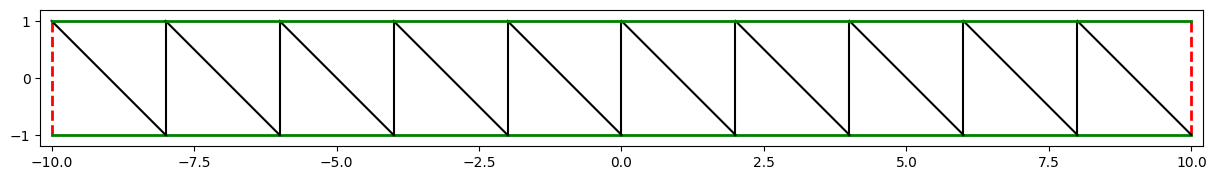

In [1286]:
def check_labels(Edges, ax = None): 
    """Checks the labelling"""

    if ax is None:
        _, ax = plt.subplots( figsize=(15,3))


    lw = 2

    for E in Edges:
        px, py = E.P 
        qx, qy = E.Q
        match E.Type:
            case EdgeType.INNER:
                ax.plot([px, qx], [py, qy], 'k') 

            case EdgeType.GAMMA:
                ax.plot([px, qx], [py, qy], 'g', linewidth=lw)

            case EdgeType.SIGMA_L:
                ax.plot([px, qx], [py, qy], '--r', linewidth=lw)

            case EdgeType.SIGMA_R:
                ax.plot([px, qx], [py, qy], '--r', linewidth=lw)

    d = 0.2
    ax.axis('square')
    ax.set_xlim([-R-d,R+d])
    ax.set_ylim([-H-d,H+d])

check_labels(Edges)


Checking the orientation of the normals...

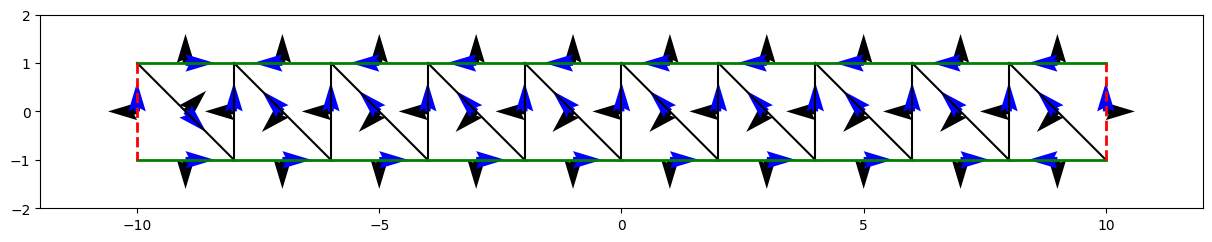

In [1287]:
def CheckNormals(Omega, Vertices, Edges):
    Normals = np.array( [ E.N for E in Edges])
    Tangents = np.array( [ E.T for E in Edges])
    MidPoints = np.array( [ E.midpoint for E in Edges])
    plot_mesh(Omega)
    plt.quiver( MidPoints[:,0], MidPoints[:,1], Normals[:,0], Normals[:,1], scale=40)
    plt.quiver( MidPoints[:,0], MidPoints[:,1], Tangents[:,0], Tangents[:,1], scale=40, color='b')
    plt.xlim([-12,12])
    plt.ylim([-2,2])

CheckNormals(Omega, Vertices, Edges)

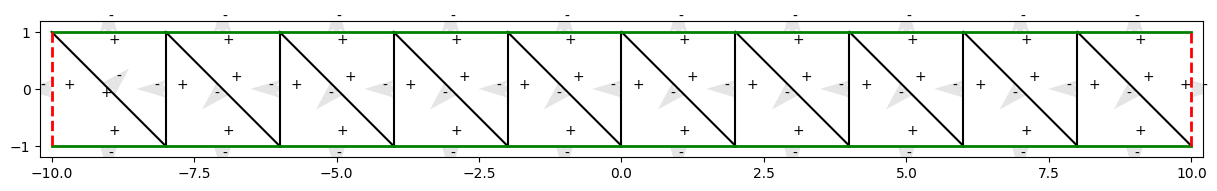

In [1288]:
def CheckPlusMinus(Omega,Edges):
    Normals = np.array( [ E.N for E in Edges])
    MidPoints = np.array( [ E.midpoint for E in Edges])
    plot_mesh(Omega)
    plt.quiver( MidPoints[:,0], MidPoints[:,1], Normals[:,0], Normals[:,1], scale=40, alpha = 0.1)
    e = 0.2
    for (m,n) in zip(MidPoints, Normals):
        plt.text( m[0]+e*n[0], m[1]+ e*n[1], '-')
        plt.text( m[0]-e*n[0], m[1]- e*n[1], '+')
    
CheckPlusMinus(Omega,Edges)

In [1316]:
class TrefftzSpace:
    '''Defines a finite dimensional Trefftz space given
    a mesh, the number of plane-waves per element and 
    the wave-numbers.

    It can create test and trial functions, aswell as 
    actual functions.
    '''

    def __init__( self, Omega, DOF_per_element : tuple[int], kappa : dict[str, float] ):
        self.Omega = Omega
        self.N_elements = Omega.ne
        self.kappa = np.zeros(self.N_elements,dtype=np.float64)
        for e in Omega.Elements():
            self.kappa[e.faces[0].nr] = kappa[e.mat]
        
        #self.kappa = np.array( [ kappa[e.mat] for e in Omega.Elements()])
        th0 = 0.
        #th0 = np.pi/6
        
        if hasattr(DOF_per_element, '__iter__'):
            assert Omega.ne == len(DOF_per_element)
            self.local_N_DOF = np.array( DOF_per_element )
        else:
            self.local_N_DOF = np.full_like(self.kappa, fill_value=DOF_per_element,dtype=np.int32)
        self.N_DOF = np.sum(self.local_N_DOF)
        # self.d =  [ list(map( lambda th: [ np.cos(th), np.sin(th)] , 
        #                               th0 + np.linspace(0, 2*np.pi, N, endpoint=False)))  for N in self.local_N_DOF] 

        self.d = [ np.array([[np.cos(th0 +th), np.sin(th0+th)] for th in np.linspace(0,2*pi,N,endpoint=False)]) 
                  for N in self.local_N_DOF ] 


        self.DOF_ownership = np.repeat( range(self.N_elements), self.local_N_DOF)
        self.DOF_start = np.cumsum(self.local_N_DOF) - self.local_N_DOF
        self.DOF_end = np.cumsum(self.local_N_DOF)
        self.DOF_range = [ list(range(s,e)) for (s,e) in zip(self.DOF_start,self.DOF_end)]
        self.global_to_local = np.array( [ n for N in self.local_N_DOF for n in range(N)])

    @property
    def TestFunctions( self ):
        return [ TestFunction( k= self.kappa[self.DOF_ownership[n]], d=self.d[self.DOF_ownership[n]][self.global_to_local[n]]) for n in range(self.N_DOF)]
    @property
    def TrialFunctions( self ):
        return [ TestFunction( k= self.kappa[self.DOF_ownership[n]], d=self.d[self.DOF_ownership[n]][self.global_to_local[n]]) for n in range(self.N_DOF)]



class TrefftzFunction:
    def __init__( self, V, DOFs = 0.):
        '''Returns a Trefftz function with degrees of freedom set to "DOFs"'''
        self.V = V
        self.coeffs = DOFs


    def Element(self, x, y ):
        return self.V.Omega(x,y).nr
    
    @property
    def DOFs( self ):
        return self._DOFs

    
    @DOFs.setter
    def DOFs( self, values):
        if hasattr(values, '__iter__'):
            assert self.V.N_DOF == len(values)
            self._DOFs = np.array(values)
        else:
            self._DOFs = np.full( self.V.N_DOF, values, dtype=np.complex128)


    def __call__(self, x, y ):
        e = self.Element(x,y)
        k = self.V.kappa[e]
        P = self.coeffs[self.V.DOF_range[e]]
        D = self.V.d[e]

        r = np.array([x,y])
        y = sum( p*np.exp(1j*k*dot(d,r)) for (p,d) in zip(P,D) )
        return y 

from collections import namedtuple

TestFunction = namedtuple("TestFunction", ["k", "d"])

    

In [1375]:
#V = TrefftzSpace(Omega, np.tile([5,5], Omega.ne//2),{"Omega_i" : 5. , "Omega_e" : 4.})


Nth = 7
V = TrefftzSpace(Omega, Nth, {"Omega_i" : 4. , "Omega_e" : 4.})


In [1376]:
# class TrefftzFun:
#     def __init__( self, Omega : Mesh, Np : list[int], kappa : list[float]):
#         assert Omega.ne == len(Np)
#         self.Ncoef = sum(Np) 
#         self.Np = Np
#         self.coefs = np.zeros(self.Ncoef, dtype=np.complex128)
#         self.kappa = kappa
       
#         self.e_to_coef = np.zeros( (Omega.ne,2), dtype=np.int32)
#         i = 0
#         for e in range(Omega.ne):
#             self.e_to_coef[e,:] = np.array( i, Np[e])
#             i += Np[e]
    

#     def set_coeffs( self, coeffs):
#         self.coefs = coeffs


#     def __call__(self, x, y ):
#         e_ID = Omega(x,y).nr
#         k = self.kappa[e_ID]
#         id0 = self.e_to_coef[e_ID,0]
#         y = sum( [self.coefs[id0+n] * np.exp(1j*k*(x*np.cos(th) + y*np.sin(th))) 
#                   for (n,th) in enumerate(np.linspace(0,2*np.pi, self.Np[e_ID], endpoint=False))] )
#         return y 



In [1377]:
# Nth = 3
# Np = np.full(Omega.ne, Nth, dtype=np.int32) #homogeneous number of plane waves
# k_in = 70
# k_out = 7
# kappa = [ k_out if e.mat == "Omega_e" else k_in for e in Omega.Elements()]
# f = TrefftzFun(Omega, Np, kappa)

# Naive Implementation:

This implementation should not be stable

In [1378]:
# Phi = V.TrialFunctions
# Psi = V.TestFunctions # currently the same spaces 
# for e_ID, K in enumerate(V.Omega.Elements(VOL)):
#     for  n in V.DOF_range[e_ID]:
#         phi = Phi[n]
#         for s_ID, E in enumerate(K.edges):
#             match E.type:
#                 case EdgeType.INNER:
#                     for m in V.DOF_range[e_ID]:
#                         psi = Psi[m]
#                         A[m,n] += same_elem_term(phi, psi, E)

#                     for m in V.DOF_range[ Neighbours[e_ID, s_ID] ]: 
#                         psi = Psi[m]
#                         A[m,n] += neighbour_elem_term(phi, psi, E)


#                 case EdgeType.GAMMA:
#                     for m in V.DOF_range[e]:
#                         psi = Psi[m]
#                         A[m,n] += Gamma_term(phi, psi, E)
                         
#                 case EdgeType.SIGMA_L:
#                     pass
#                 case EdgeType.SIGMA_R:
#                     pass



#### different terms

In [1379]:

def Gamma_term(phi, psi, edge):

    kd_m = psi.k * psi.d    
    kd_n = phi.k * phi.d
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T


    if np.isclose([kd_m],[kd_n],1E-3).all() :
        return -1j*dot(kd_m, N) * norm(Q-P)    
        
    else:    
        return dot(kd_m, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )

def Inner_term(phi, psi, edge):

    kd_m = psi.k * psi.d    
    kd_n = phi.k * phi.d
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T

    if np.isclose([kd_m],[kd_n],1E-3).all() :
        return -1j*dot(kd_m, N) * norm(Q-P)
    else:
        return 0.5 * dot(kd_m + kd_n, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )

def Sigma_term(phi, psi, edge, Np = 15):

    k = phi.k 
    d_n = phi.d
    d_m = psi.d

    d_nx, d_ny = d_n 
    d_mx, d_my = d_m

    kH = k*H
    kd_m = k * d_m    
    kd_n = k * d_n
    kd_mn = kd_n - kd_m
    
    P = edge.P 
    Q = edge.Q 
    N = edge.N
    T = edge.T

    x  = P[0]

    I1 = 2/(1j*kH)
    if np.isclose(d_ny,0):
        I1 = I1*kH 
    else:
        I1 = I1*sin(kH*d_ny)/d_ny

    if np.isclose(d_my,0):
        I1 = I1*kH 
    else:
        I1 = I1*sin(kH*d_my)/d_my

        # I1  = 2/(1j*sqrt(kH))*sin(kH*d_ny)/d_ny*sin(kH*d_my)/d_my
    
    I1 += kH**2*sum([1/(1j*sqrt(kH**2-(s*pi)**2+0j))* (sin(kH*d_ny+s*pi)/(kH*d_ny+s*pi)+sin(kH*d_ny-s*pi)/(kH*d_ny-s*pi)) 
                                            * (sin(kH*d_my+s*pi)/(kH*d_my+s*pi)+sin(kH*d_my-s*pi)/(kH*d_my-s*pi)) 
                                            for s in range(1,Np)])
    
    if np.isclose([kd_m],[kd_n],1E-3).all() :
        I2 = -1j*dot(kd_m, N) * norm(Q-P)    
    else:
        I2 = dot(kd_n, N) / dot( kd_mn, T) * ( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )
    
    return dot(d_n, N) * dot( d_m , N) * exp (1j*k*(d_nx - d_mx)*x)*I1 + I2


def exact_RHS(psi, E, Np=15, s=0):
    k = psi.k 
    d = psi.d
    d_x = d[0]
    d_y = d[1]
    N = E.N
    if s == 0:
        if np.isclose(d_y,0):
            return 4*1j/sqrt(2*H) * dot( d, N) * exp(-1j*k*(1-d_x)*R)*k*H
        else:
            return 4*1j/sqrt(2*H) * dot( d, N) * exp(-1j*k*(1-d_x)*R)*sin(k*H*d_y)/d_y
    else:
        return 2*1j*k*sqrt(H)*dot(d,N)*exp(-1j*(sqrt(k**2 - (s*pi/H)**2) - k*d_x)*R)*(sin(k*H*d_y+s*pi)/(k*H*d_y+s*pi)+sin(k*H*d_y-s*pi)/(k*H*d_y-s*pi))


In [1380]:
N_DOF = V.N_DOF
A = np.zeros((N_DOF,N_DOF), dtype=np.complex128)
b = np.zeros((N_DOF), dtype=np.complex128)


Phi = V.TrialFunctions
Psi = V.TestFunctions # currently the same spaces 
for (s,E) in enumerate(Edges):
    match E.Type:
        case EdgeType.INNER:
            K_plus, K_minus = E.Triangles
            for n in V.DOF_range[K_plus]:
                phi = Phi[n]
                for m in V.DOF_range[K_plus]:
                    psi = Psi[m]
                    A[m,n] += Inner_term(phi, psi, E)

            for n in V.DOF_range[K_minus]:
                phi = Phi[n]
                for m in V.DOF_range[K_plus]:
                    psi = Psi[m]
                    A[m,n] += Inner_term(phi, psi, E)

            for n in V.DOF_range[K_plus]:
                phi = Phi[n]
                for m in V.DOF_range[K_minus]:
                    psi = Psi[m]
                    A[m,n] -= Inner_term(phi, psi, E)

            for n in V.DOF_range[K_minus]:
                phi = Phi[n]
                for m in V.DOF_range[K_minus]:
                    psi = Psi[m]
                    A[m,n] -= Inner_term(phi, psi, E)


        case EdgeType.GAMMA:
            K = E.Triangles[0]
            for m in V.DOF_range[K]:
                psi = Psi[m]
                for n in V.DOF_range[K]:
                    phi = Phi[n]
                    A[m,n] += Gamma_term(phi, psi, E)
                
        case EdgeType.SIGMA_L:
            K = E.Triangles[0]
            for m in V.DOF_range[K]:
                psi = Psi[m]
                for n in V.DOF_range[K]:
                    phi = Phi[n]
                    A[m,n] += Sigma_term(phi, psi, E)

        case EdgeType.SIGMA_R:
            K = E.Triangles[0]
            for m in V.DOF_range[K]:
                psi = Psi[m]
                for n in V.DOF_range[K]:
                    phi = Phi[n]
                    A[m,n] += Sigma_term(phi, psi, E)

for E in Edges:
    match E.Type:                
        case EdgeType.SIGMA_L:
            K = E.Triangles[0]
            for m in V.DOF_range[K]:
                psi = Psi[m]
                b[m] += exact_RHS(psi, E, Np=15, s=1)    
        case EdgeType.SIGMA_R:
            pass


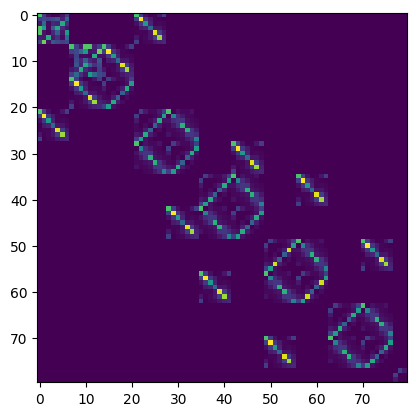

In [1381]:
plt.imshow(np.abs(A[:80,:80]))
#print(np.linalg.cond(A))

In [1382]:
DOFs = np.linalg.solve(A,b)

In [1383]:
f = TrefftzFunction(V,DOFs)

In [1384]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


(-1.0, 1.0)

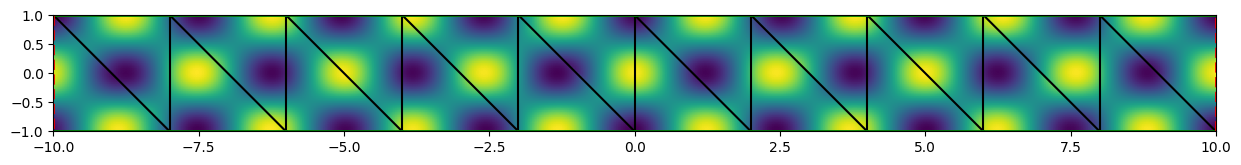

In [1385]:
_, ax = plt.subplots( figsize=(15,3))
ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
plot_mesh(Omega, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])

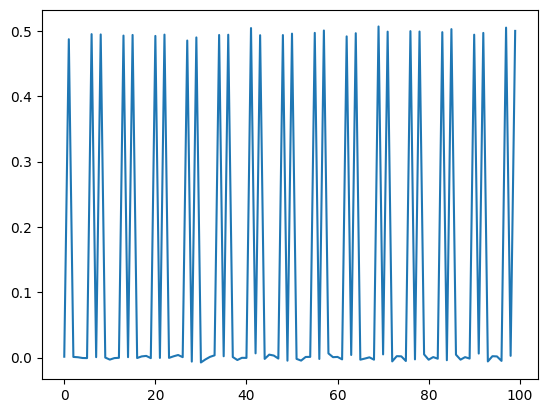

In [1388]:
plt.plot(np.real(DOFs[:100]))

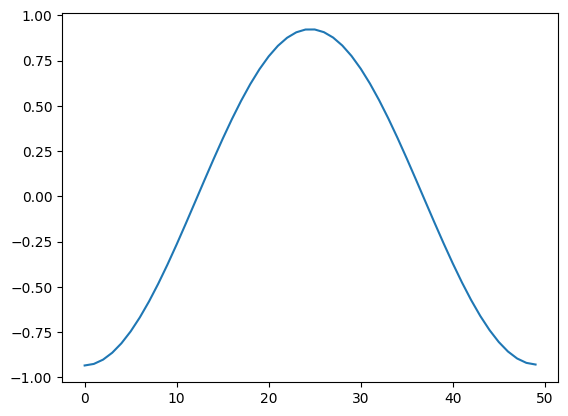

In [1390]:
plt.plot(np.real(Z[:,0]))

saving file: frame_000


FileNotFoundError: [Errno 2] No such file or directory: './2nd_mode/frame_000.png'

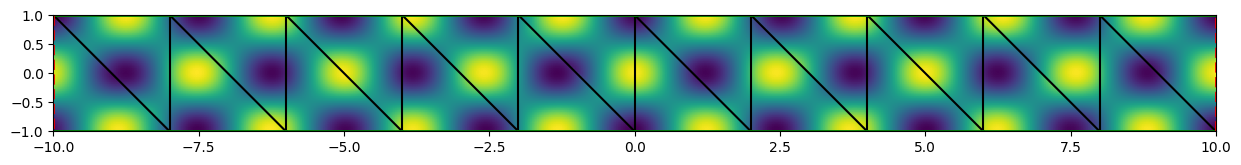

In [1393]:
def save_field(Z,n,T,t, folder = './2nd_mode/'):
    w = 5*2*pi/T
    _, ax = plt.subplots( figsize=(15,3))
    ax.imshow(np.real(Z*exp(-1j*w*t)), origin="lower", extent=[-R,R,-H,H])
    plot_mesh(Omega, ax)
    ax.axis('square')
    ax.set_xlim([-R,R])
    ax.set_ylim([-H,H])
    filename = f'frame_{n:03d}.png'
    print(f'saving file: {filename}')
    plt.savefig(f'{folder}{filename}')
    plt.close()

N = 100
T = 5
for (n,t) in enumerate(np.linspace(0,T,N)):
    save_field(Z,n,T,t, folder = './2nd_mode/')
